# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import requests
import inflection
import seaborn as sns
import xgboost as xgb

from flask                 import Flask
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Helper functions

In [2]:
def cross_validation(xtraining, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in range(kfold, 0, -1):
        if verbose:
            print('\nKFold number: {}'.format(k))
        # starting and ending date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ] 
        validation = x_training[ ( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date ) ] 

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        model = model.fit( xtraining, ytraining )

        # prediction
        yhat_model = model.predict( xvalidation )

        # performance
        model_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat_model ) )

        # store performance of each kfold iteration
        mae_list.append( model_result['MAE'] )
        mape_list.append( model_result['MAPE'] )
        rmse_list.append( model_result['RMSE'] )
            
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE_CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE_CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE_CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) 
    }, index=[0] )
            
    

def cramer_v(x, y):
    
    cm = pd.crosstab( x, y ).values    
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / min( kcorr - 1, rcorr - 1 ) )  


    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean(np.abs(y - yhat) / y)


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse
                         }, index=[0] )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
258802,1093,1,2014-12-08,9665,951,1,0,0,0,c,c,10450.0,6.0,2009.0,0,NaN,NaN,NaN


# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename columns

df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)
                                                                                                            
# promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
              5: 'May', 6: 'Jun',  7: 'Jul', 8: 'Aug',
              9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }  

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)  
                                     
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )                                     
                                     

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attrs = df1.select_dtypes( include=['int64', 'float64'] )
cat_attrs = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attrs.apply( np.mean )).T
ct2 = pd.DataFrame(num_attrs.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs.apply( np.std )).T
d2 = pd.DataFrame(num_attrs.apply( min )).T
d3 = pd.DataFrame(num_attrs.apply( max )).T
d4 = pd.DataFrame(num_attrs.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attrs.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attrs.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

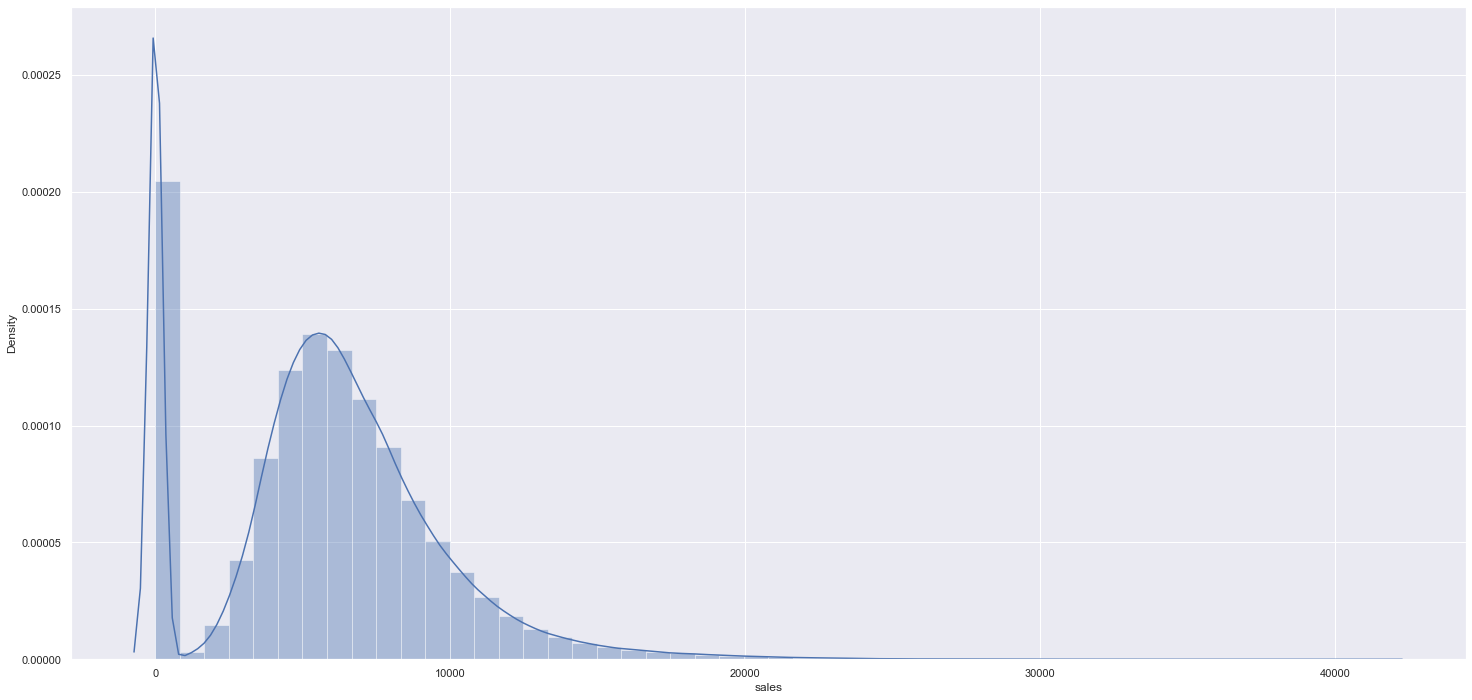

In [18]:
sns.distplot( df1['sales'] )

## 1.7.2 Categorical Attributes

In [19]:
cat_attrs.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

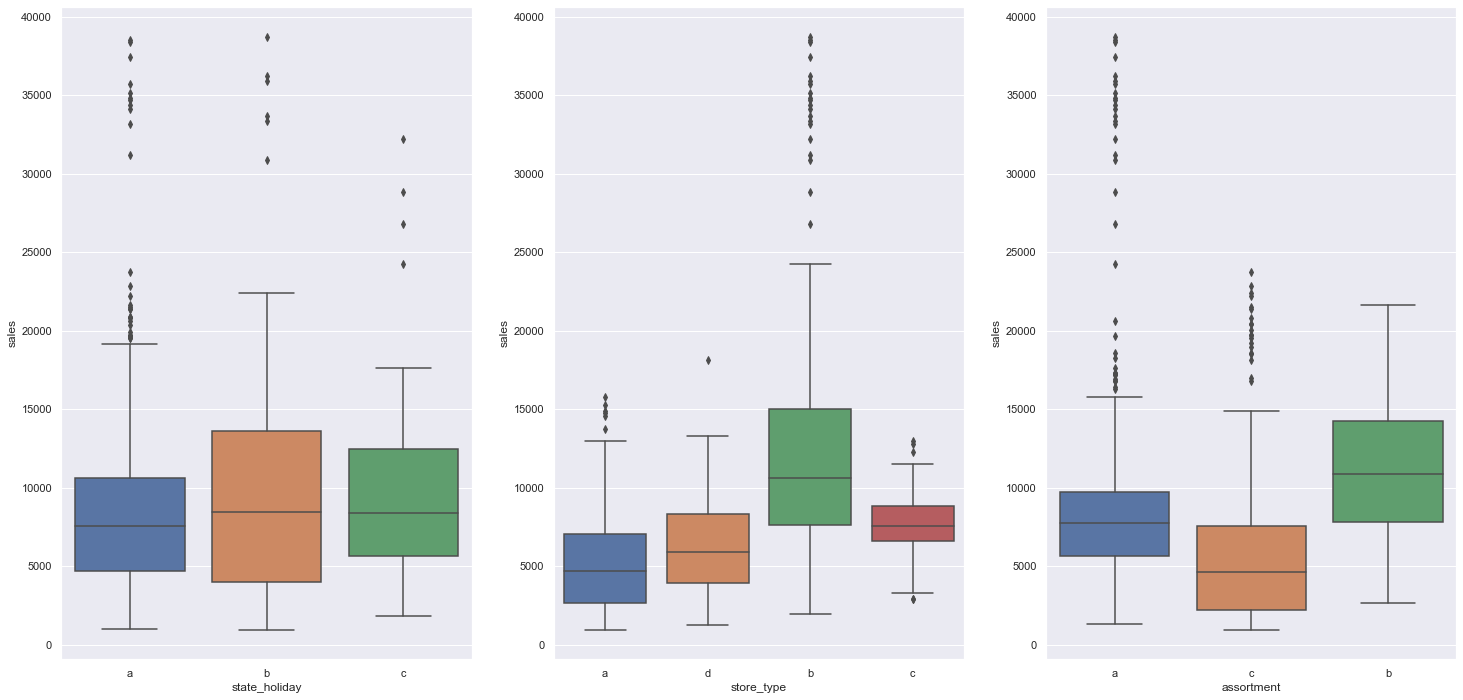

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mind Map Hypotheses

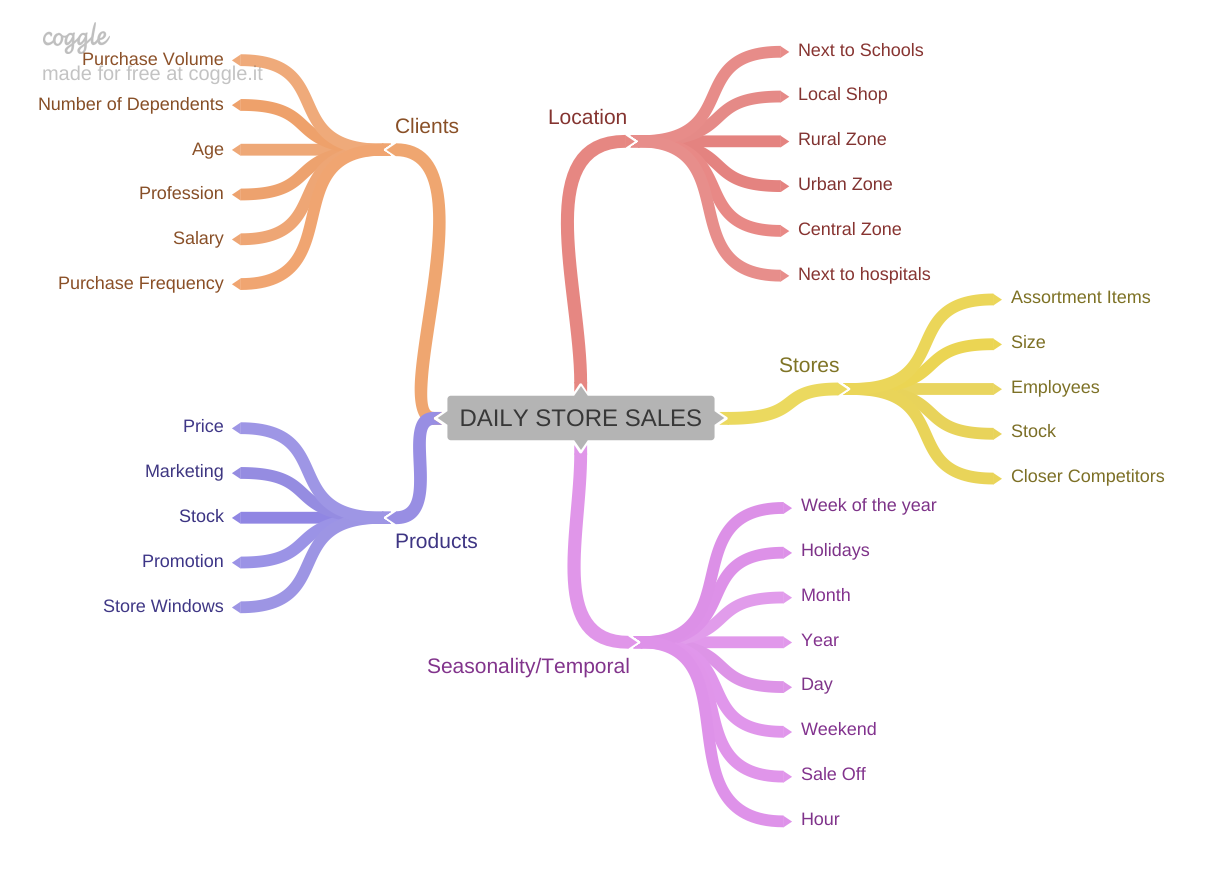

In [22]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Create Hypotheses List

### 2.2.1 Stores Hypotheses

**1.** Stores with more employees are likely to sell more.

**2.** Stores with more stock are likely sell more.

**3.** Larger stores are likely to sell more.

**4.** Stores with larger assortment items are likely to sell more.

**5.** Stores with a higher number of close competitors are likely to sell less.

**6.** Stores with the number of competitors (the longest) are likely to sell more.

### 2.2.2 Products Hypotheses

**1.** Stores that invest more in marketing strategies are likely to sell more.

**2.** Stores that display more products in store windows are likely to sell more.

**3.** Stores with lower prices are likely to sell more.

**4.** Stores with active promotions for longer are more likely to sell more.

**5.** SStores with more sales promotions days are likely to sell more.

**6.** Stores with consecutive promotions are more likely to sell more.

### 2.2.3 Temporal Hypotheses

**1.** Stores are more likely to sell less during school holidays.

**2.** Stores are more likely to sell more over the years.

**3.** Stores are more likely to sell less on weekends.

**4.** Stores are more likely to sell after the 10th of every month.

**5.** Stores that remain open during Christmas time are more likely to sell more.

**6.** Stores are more likely to sell in the second half of the year.

## 2.3 Priority Hypotheses

**1.** Stores with larger assortment items are likely to sell more.

**2.** SStores with a higher number of close competitors are likely to sell less.

**3.** Stores with the number of competitors (the longest) are likely to sell more.

**4.** Stores with active promotions for longer are likely to sell more.

**5.** Stores with more sales promotions days are likely to sell more.

**6.** Stores with consecutive promotions are likely to sell more.

**7.** Stores are likely to sell less during school holidays.

**8.** Stores are likely to sell more over the years.

**9.** Stores are likely to sell less on weekends.

**10.** Stores are likely to sell after the 10th of every month.

**11.** Stores that remain open at Christmas time are likely to sell more.

**12.** Stores are likely to sell in the second half of the year.

## Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ) , axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else "easter_holiday" if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [24]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [25]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. VARIABLE FILTERING

In [26]:
df3 = df2.copy()

## 3.1. Row Filtering

In [27]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Columns Selection

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

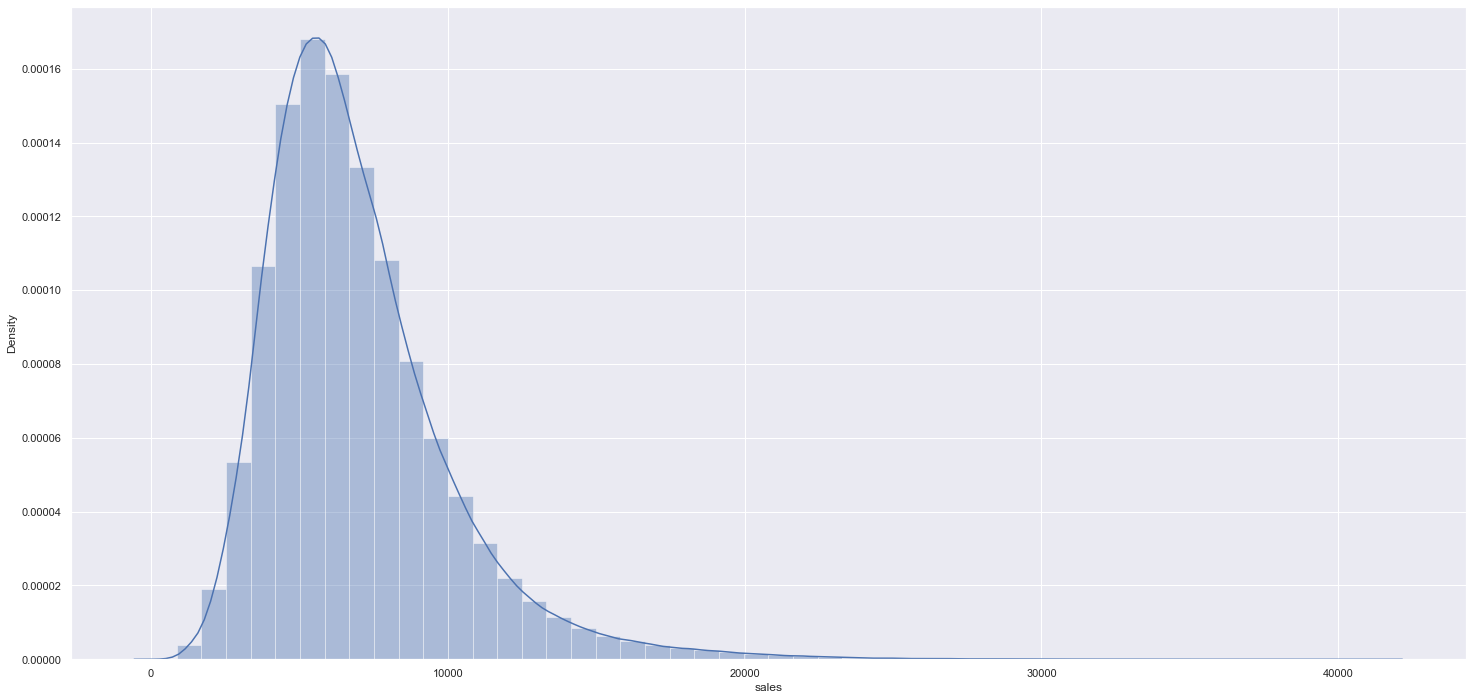

In [31]:
sns.distplot( df4['sales'] )

### 4.1.2. Numerical Variable

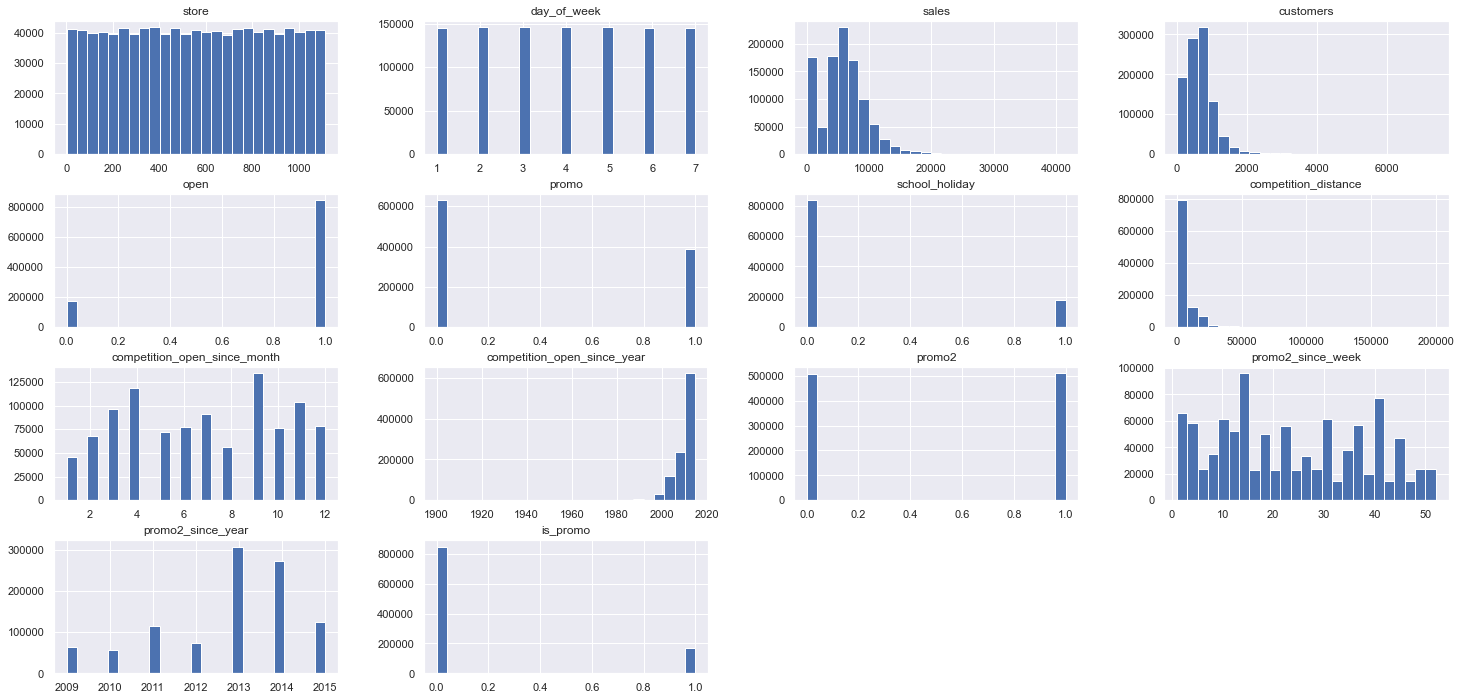

In [32]:
num_attrs.hist( bins=25 );

### 4.1.3. Categorical Variable

In [33]:
df4['store_type'].drop_duplicates()
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

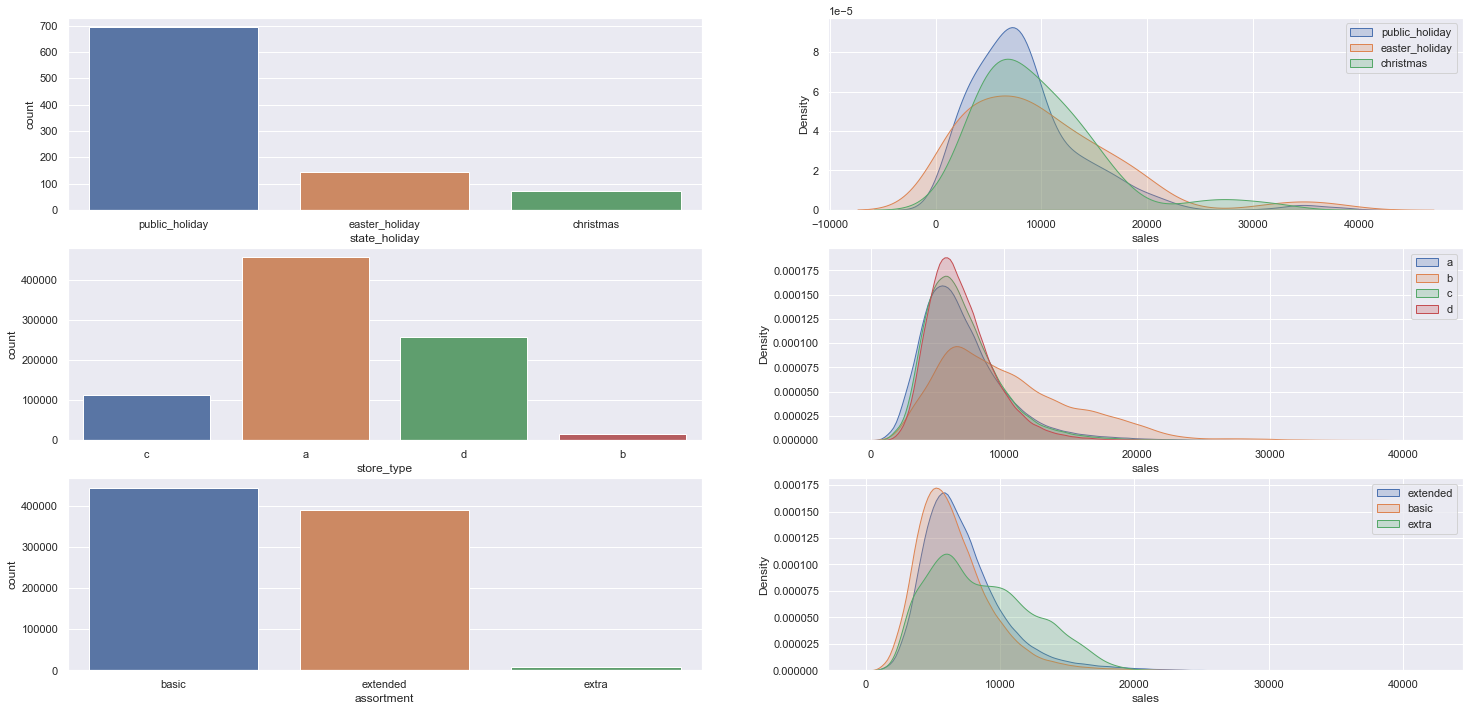

In [34]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()


## 4.2. Bivariate Analysis

### H1. Stores with larger assortment items are likely to sell more.
 - **False** | Stores with LARGER ASSORTMENT sell LESS.

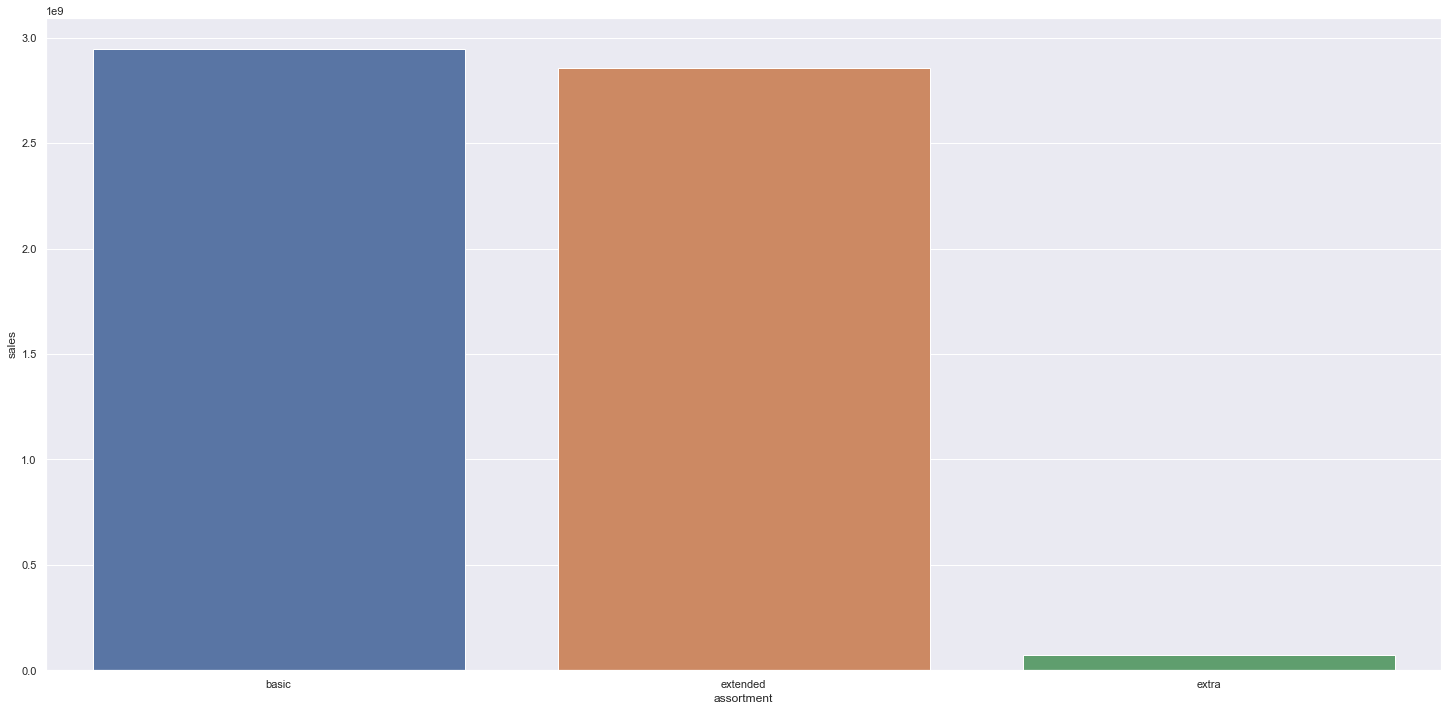

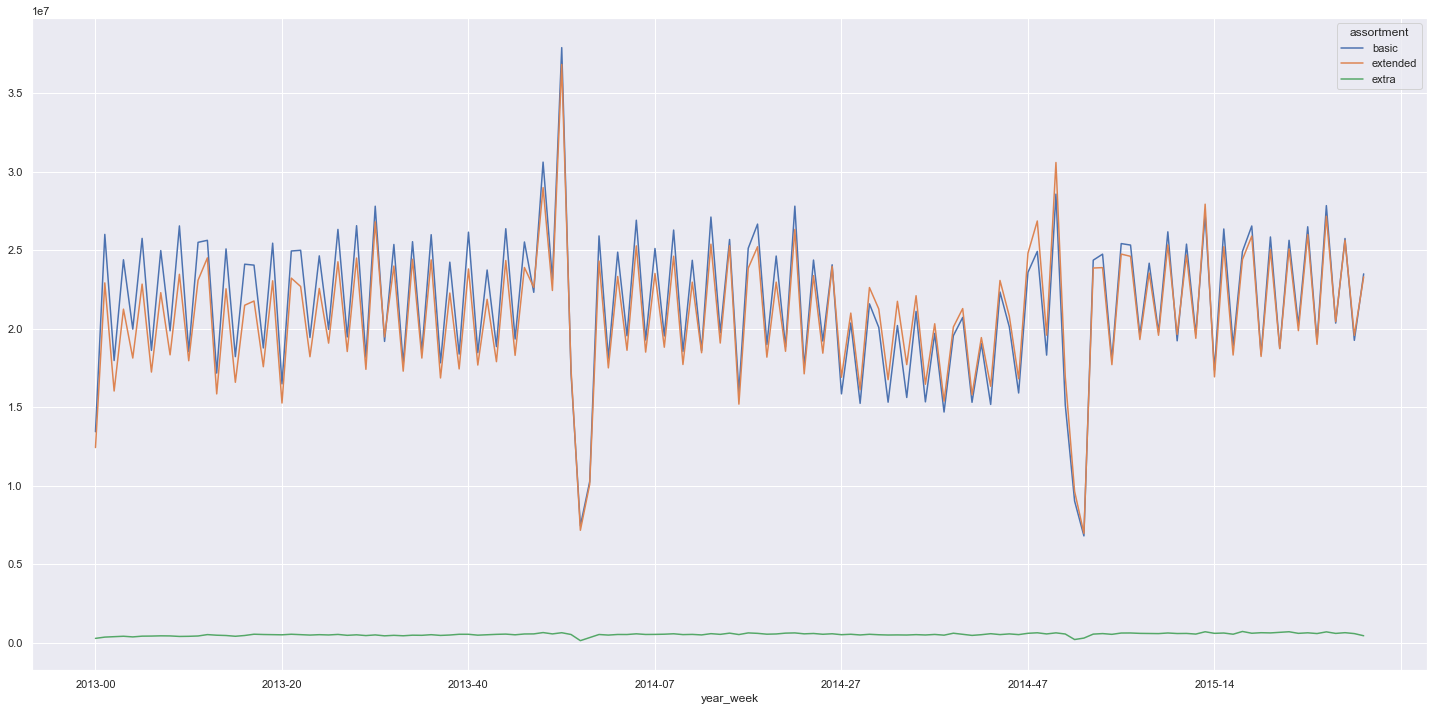

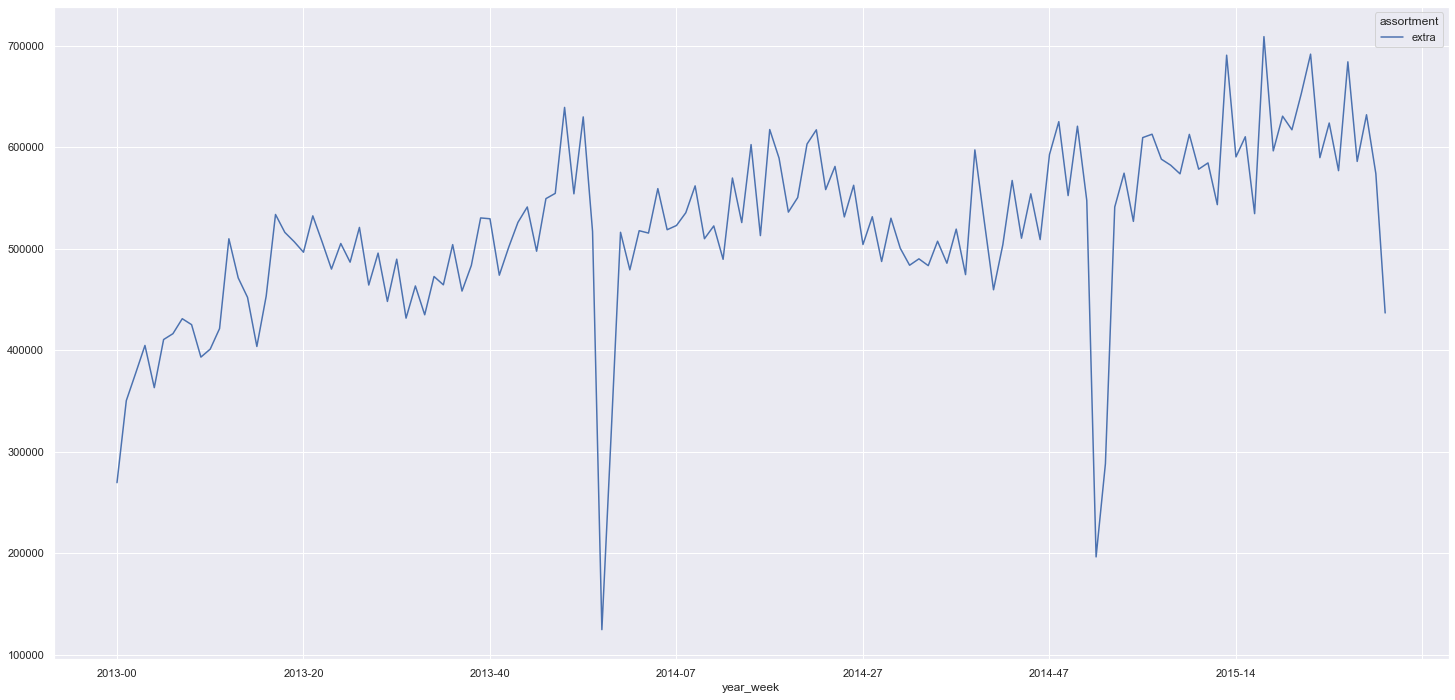

In [35]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2. Stores with a higher number of close competitors are likely to sell less.
 - **False** | Stores with a HIGHER NUMBER of CLOSE sell MORE.

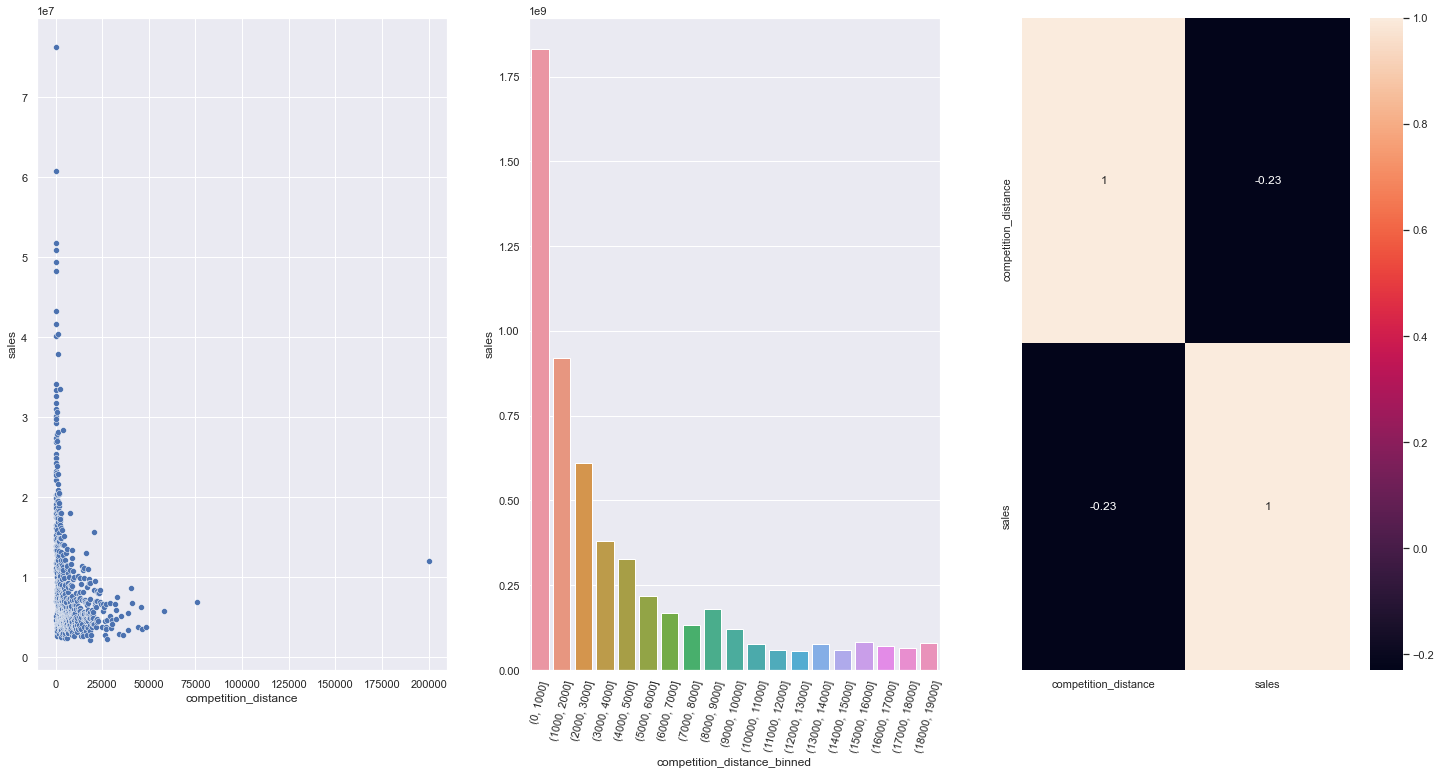

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation = 75 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores with the number of competitors (the longest) are likely to sell more.
 - **False** | Stores with the number of competitors (the longest) sell LESS.

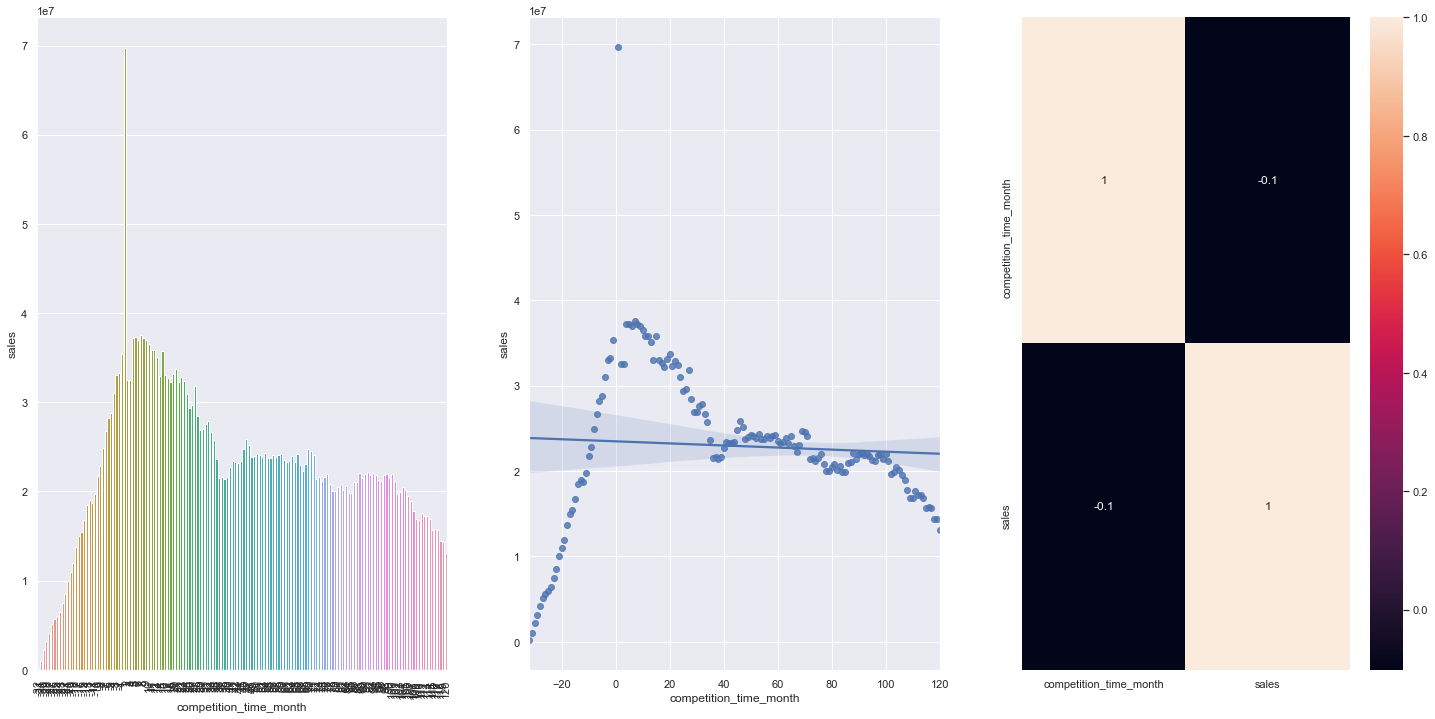

In [37]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
aux2 = aux1[( aux1['competition_time_month'] <= 120 ) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H4.** Stores with active promotions for longer are likely to sell more.
 - **False** | Stores with active promotions for longer sell LESS after a while.

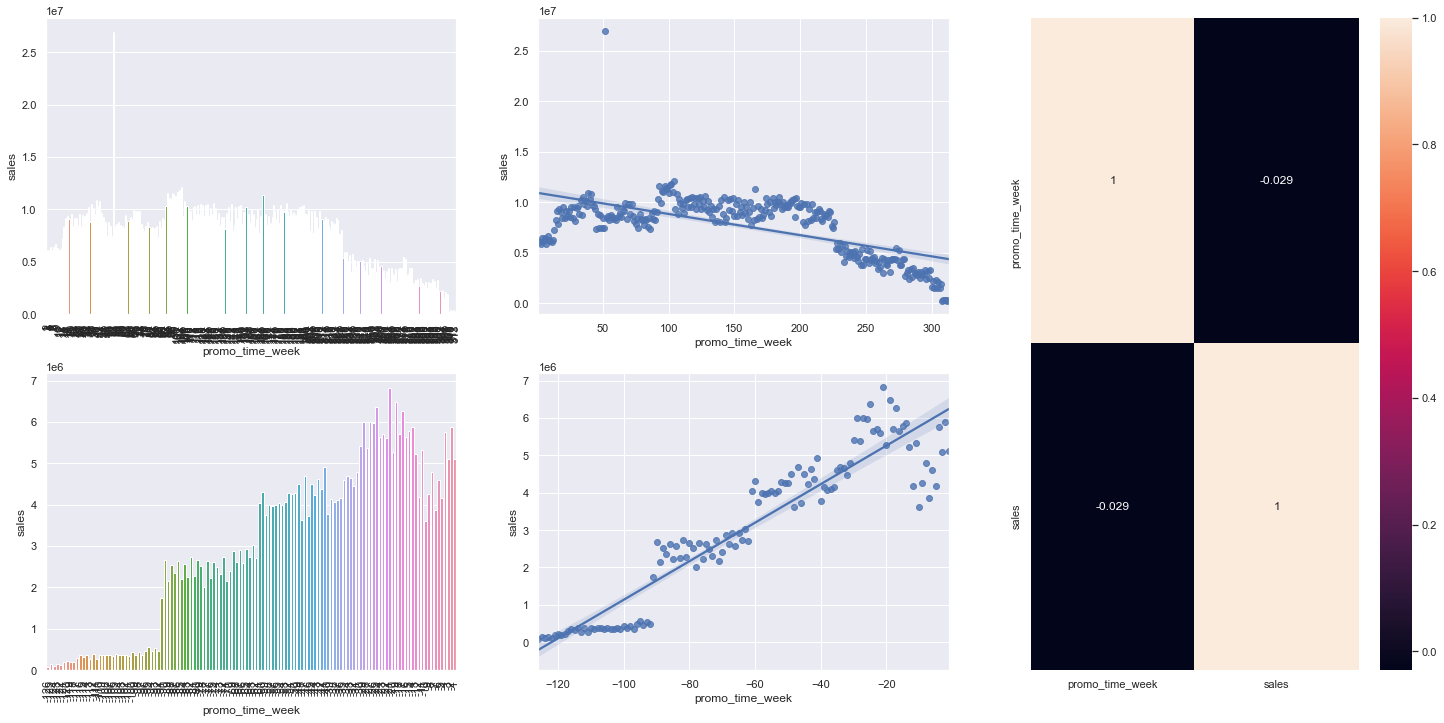

In [38]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ]  # extended promo
sns.barplot( x='promo_time_week',  y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ]  # regular promo
sns.barplot( x='promo_time_week',  y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### <s>**H5.** Stores with more sales promotions days are likely to sell more.</s>

### **H6.** Stores with consecutive promotions are likely to sell more.
 - **False** | Stores with consecutive promotions sell LESS.

In [39]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


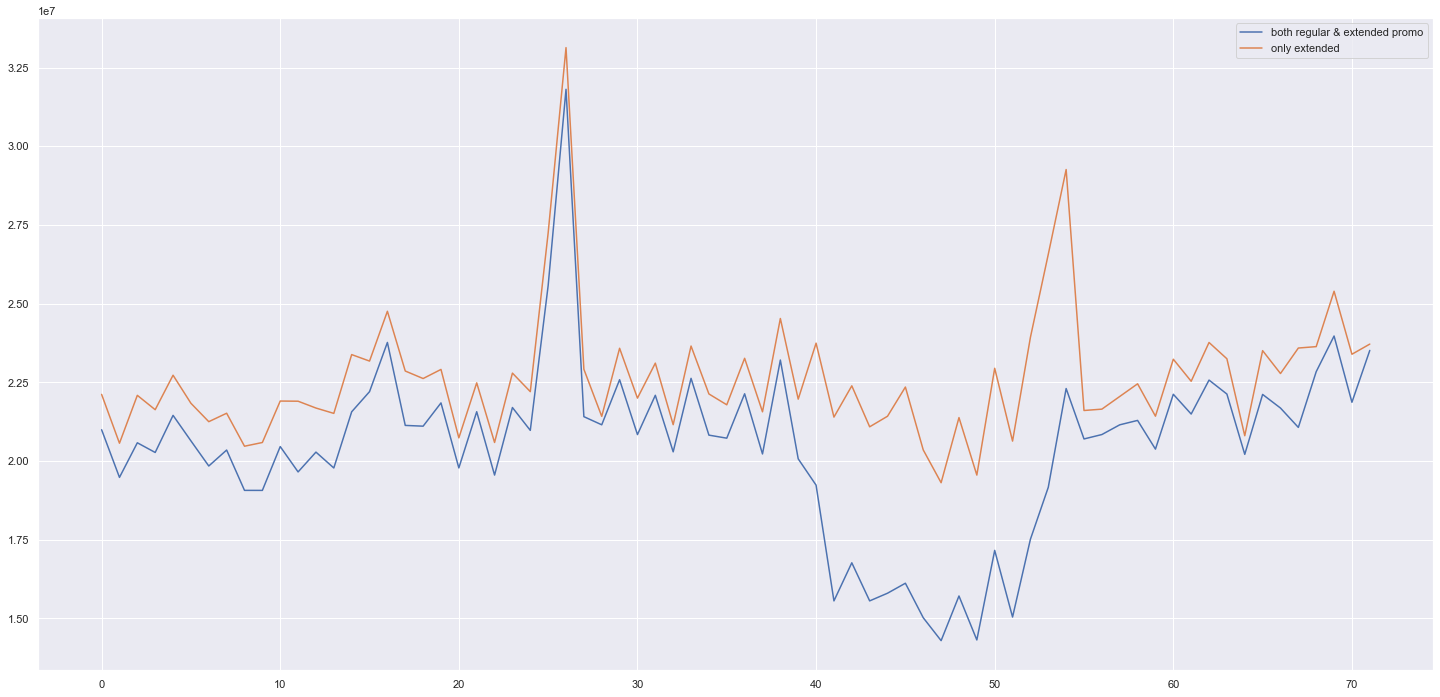

In [40]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );
plt.legend( labels=['both regular & extended promo', 'only extended'] )

### **H7.** Stores are likely to sell less during school holidays.
 - **True** | Stores sell LESS during school holidays, except July & August.

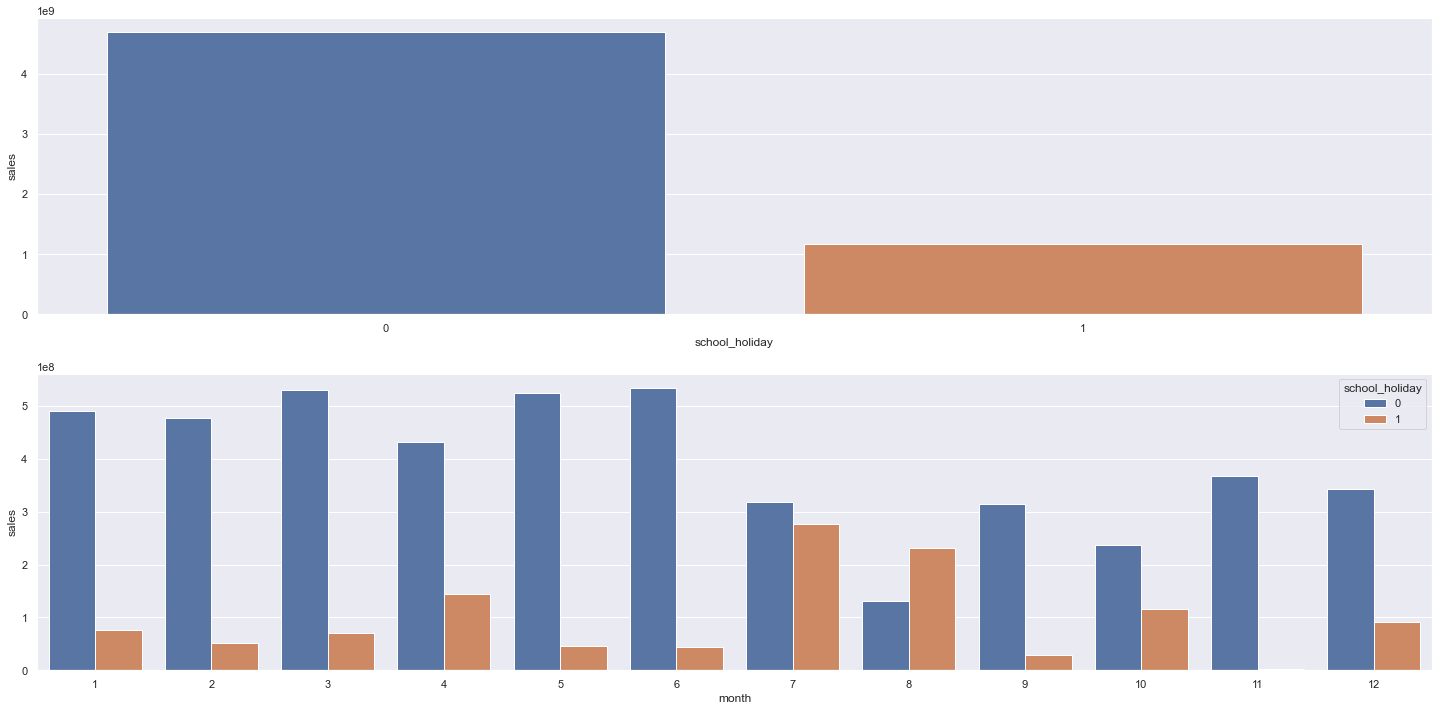

In [41]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday',  data=aux2 );


### **H8.** Stores are likely to sell more over the years.
 - **False** | Stores sell LESS over the years.

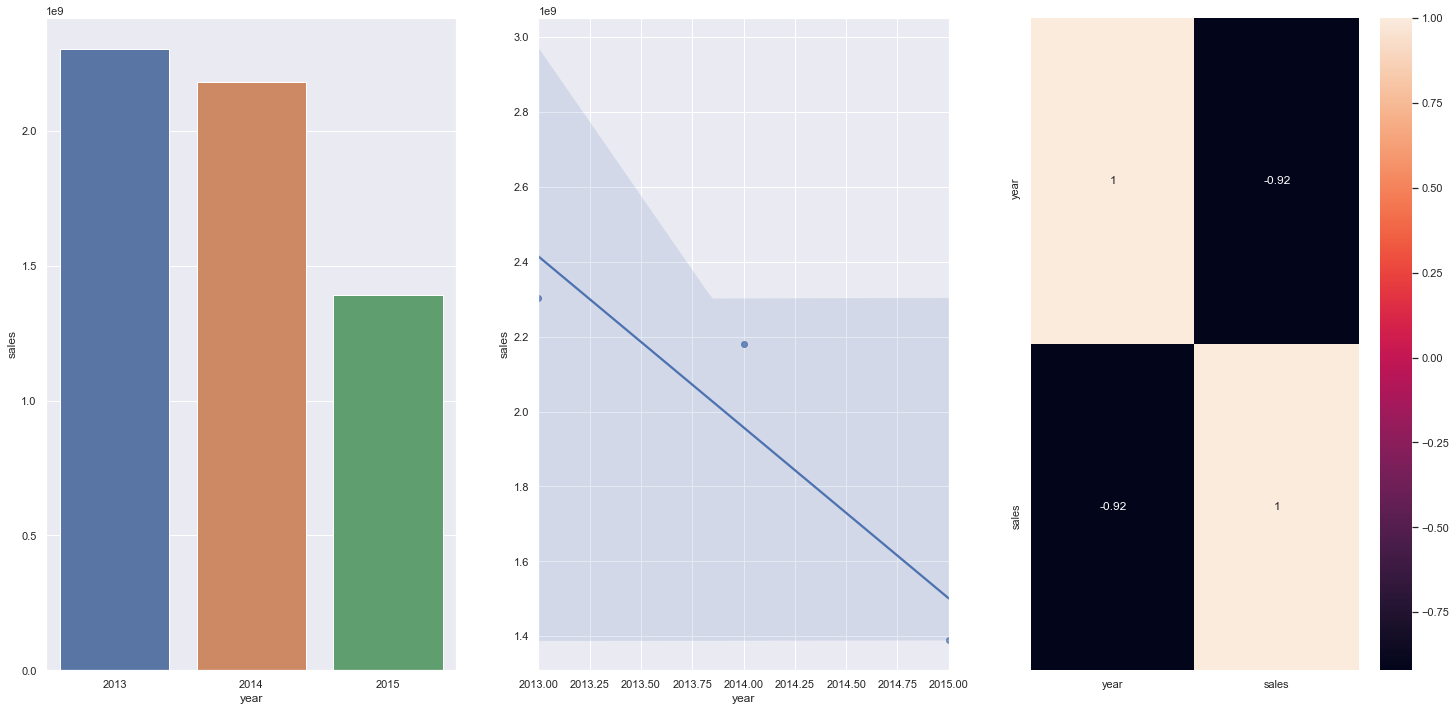

In [42]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Stores are likely to sell less on weekends.
 - **True** | Stores sell LESS on weekends.

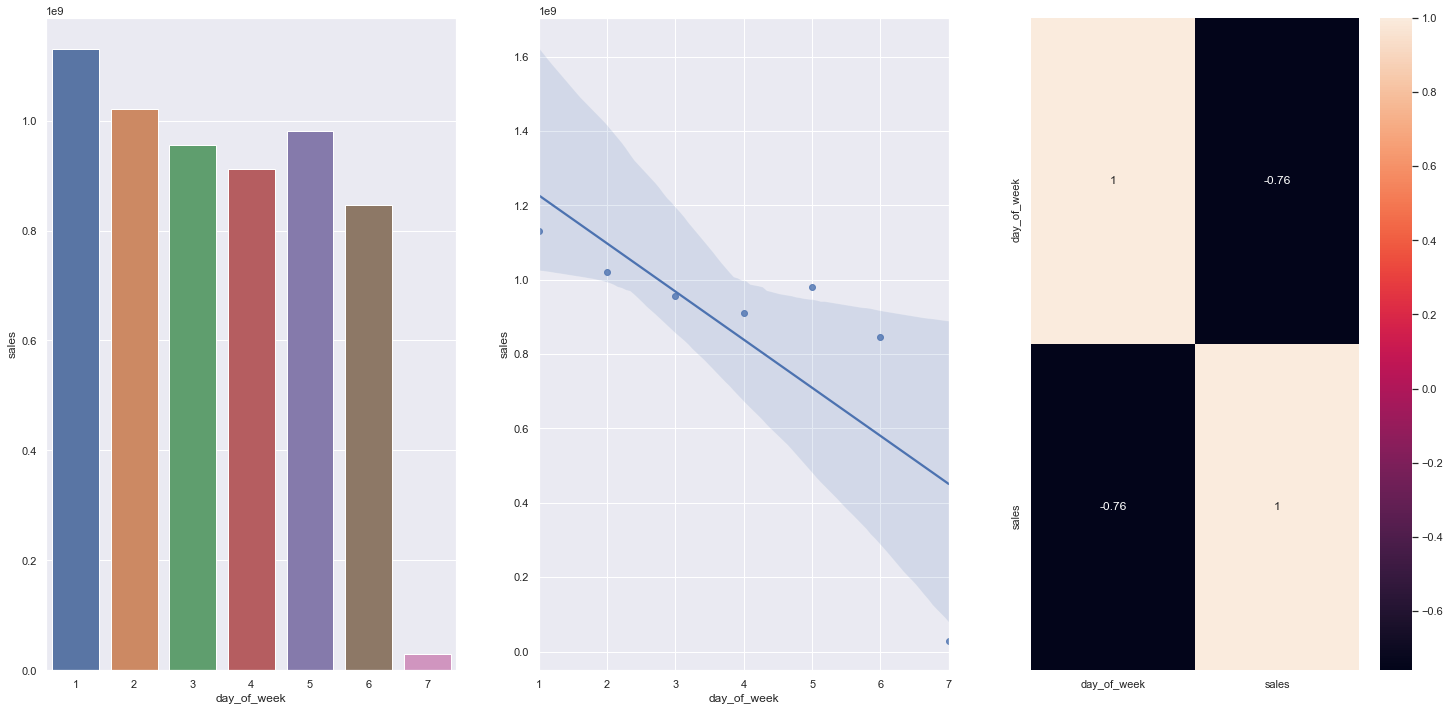

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Stores are likely to sell more after the 10th of every month.
 - **True** | Stores sell MORE after the 10th of every month.

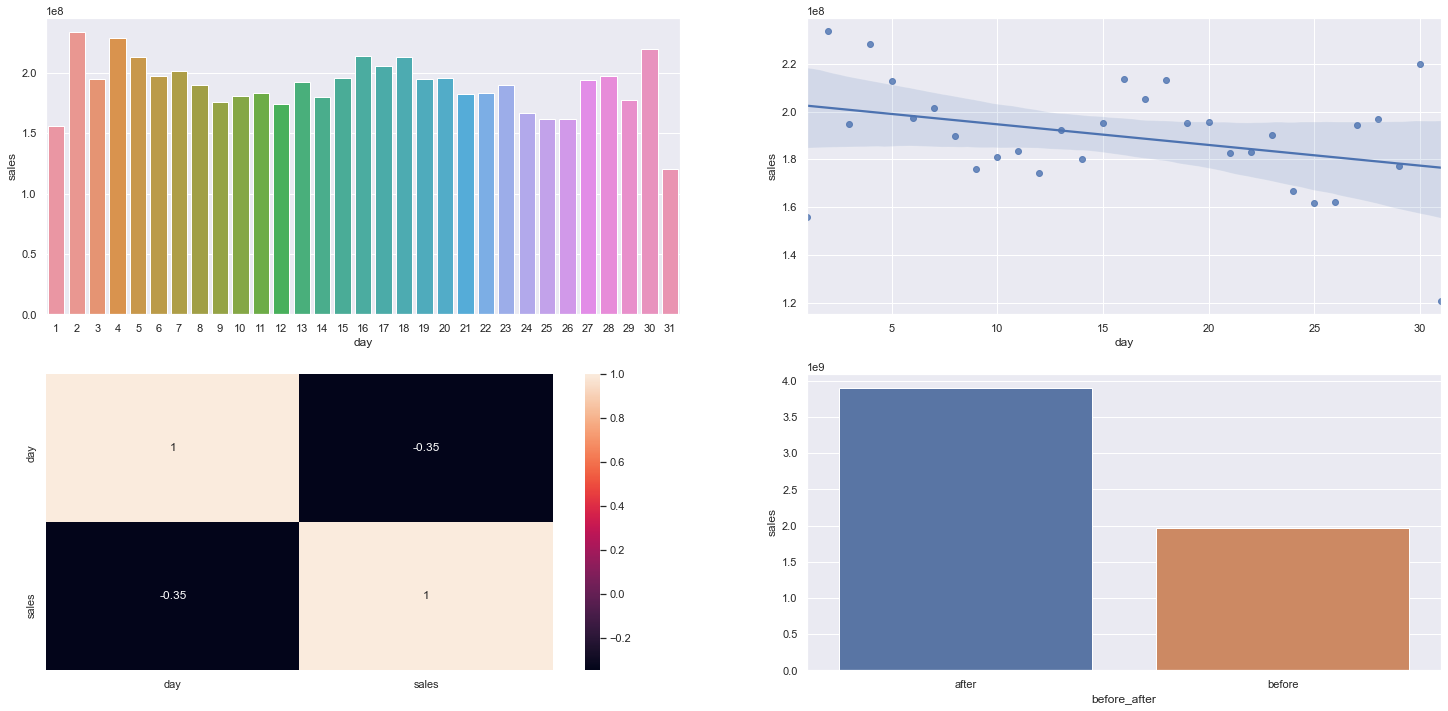

In [44]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before' if x <= 10 else 'after' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Stores that remain open at Christmas time are likely to sell more.
 - **False** | Stores sell LESS at Christmas time.

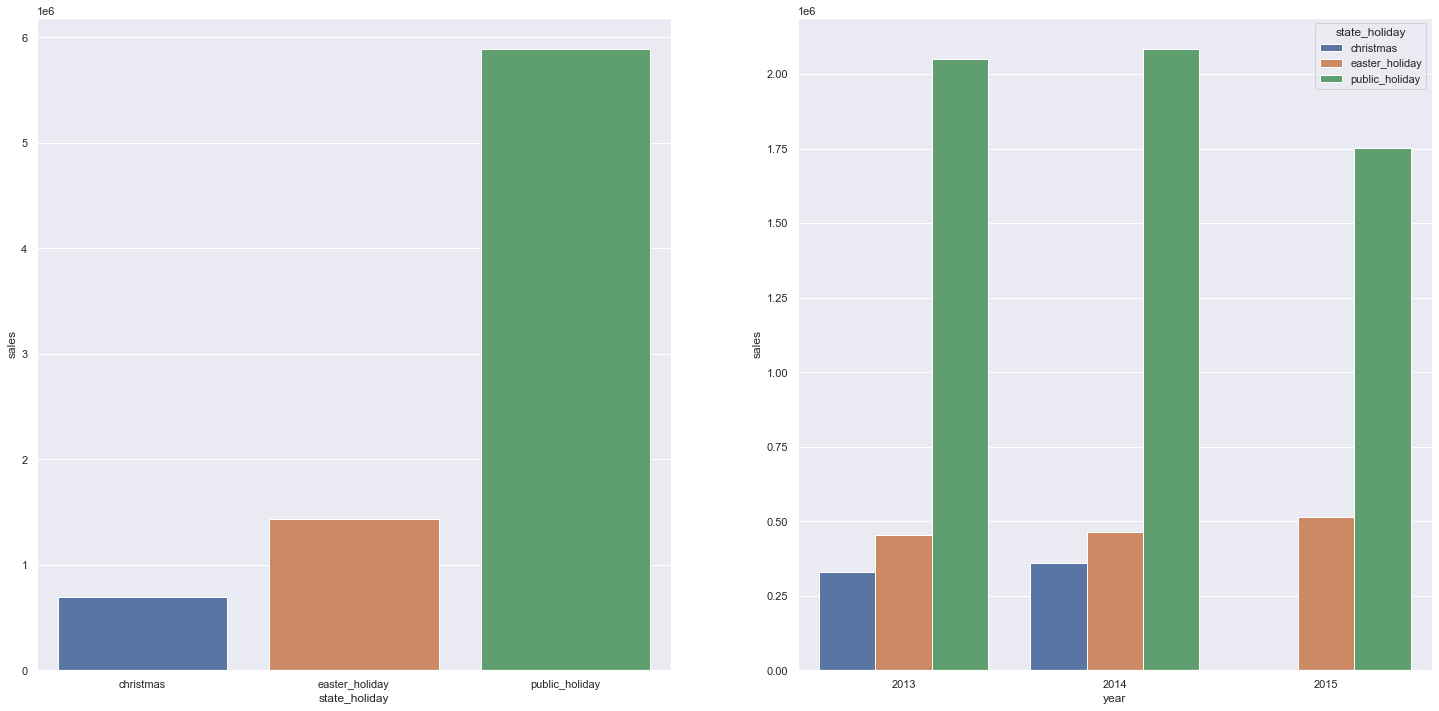

In [45]:
aux = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='state_holiday', y='sales', data=aux1 );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
plt.subplot( 1, 2, 2 )
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **H12.** Stores are likely to sell more in the second half of the year.
 - **False** | Stores sell LESS in the second half of the year.

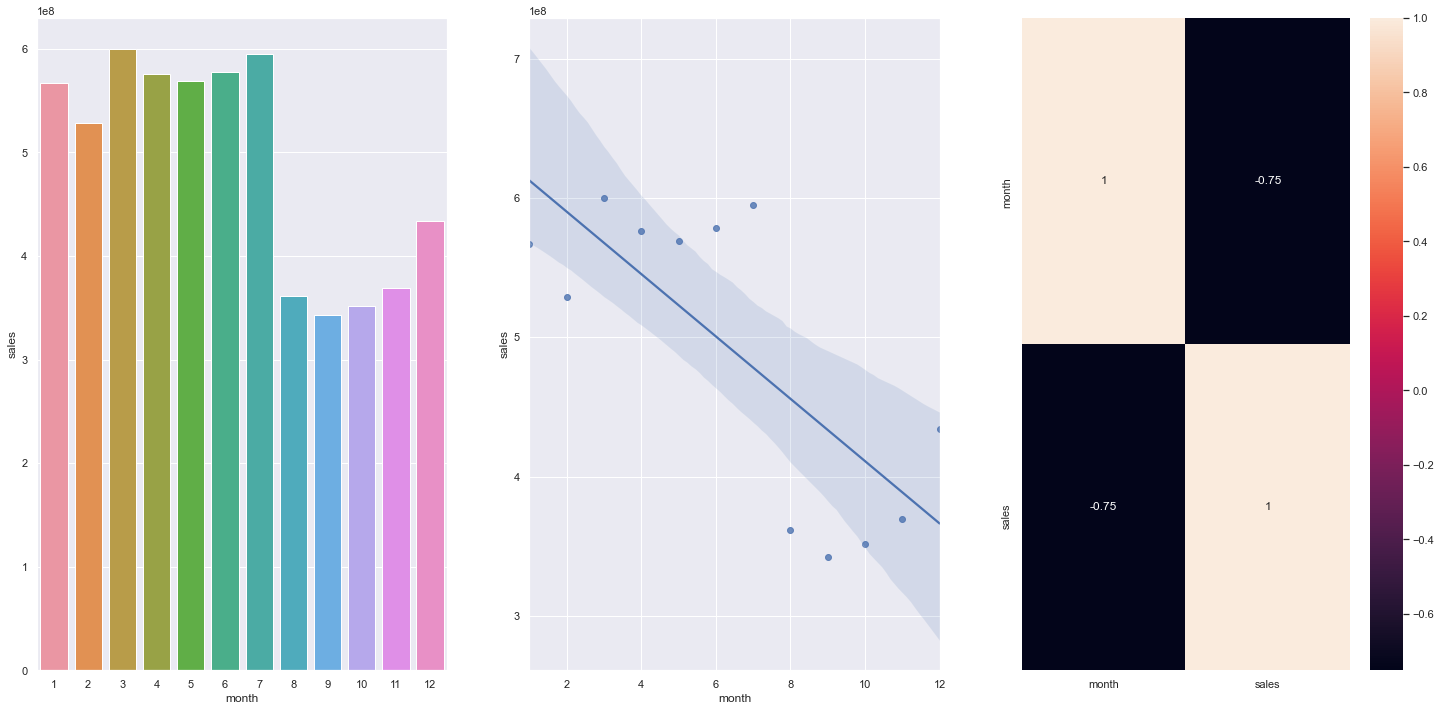

In [46]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.1. Summary of hypotheses

In [47]:
from tabulate import tabulate

In [48]:
tabs = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'True', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'True', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'False', 'Low'],
       ['H12', 'False', 'High']]

print(tabulate(tabs, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            True          Medium
H8            False         High
H9            True          High
H10           True          High
H11           False         Low
H12           False         High


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

In [49]:
num_attrs.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


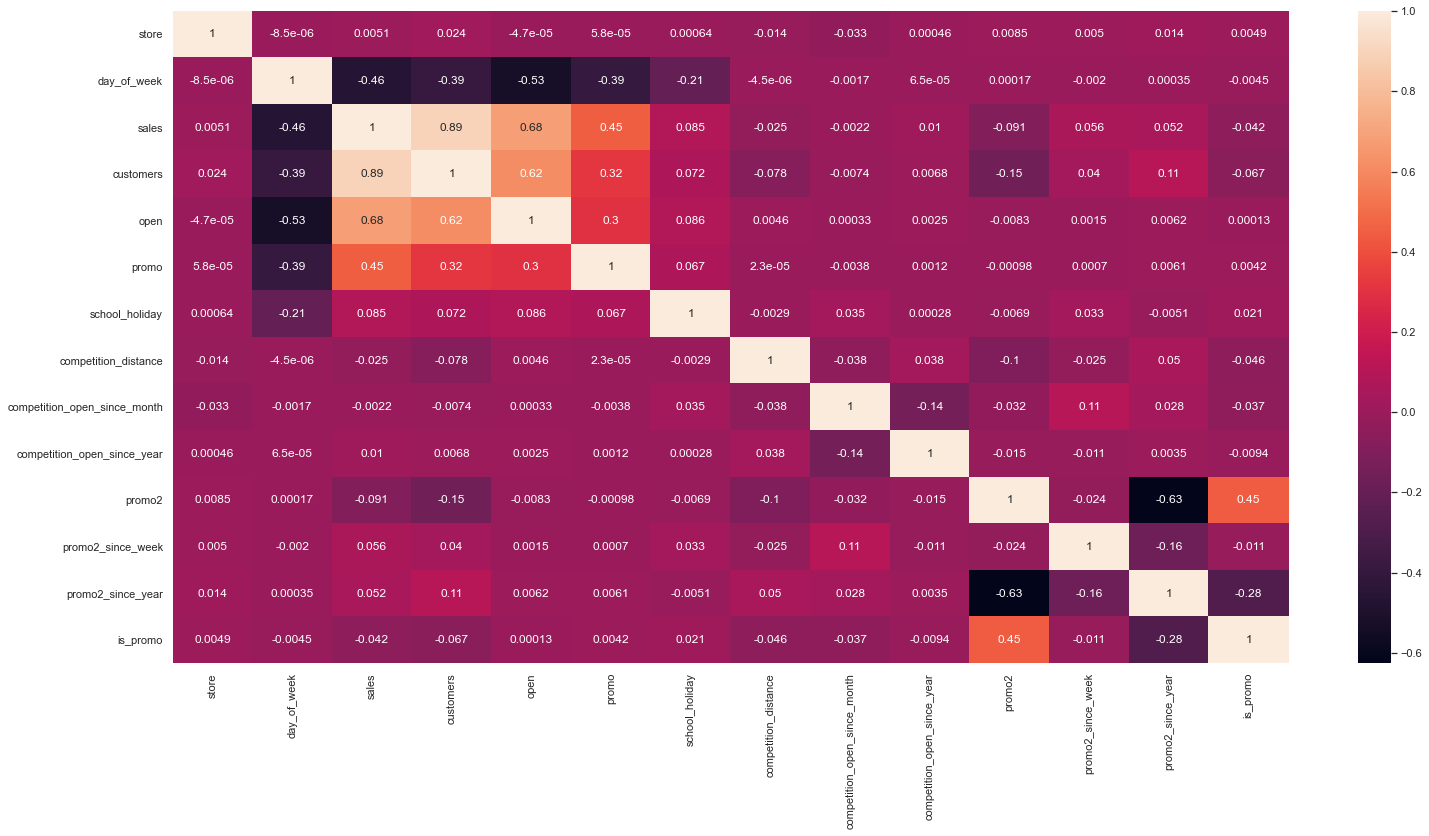

In [50]:
correlation = num_attrs.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

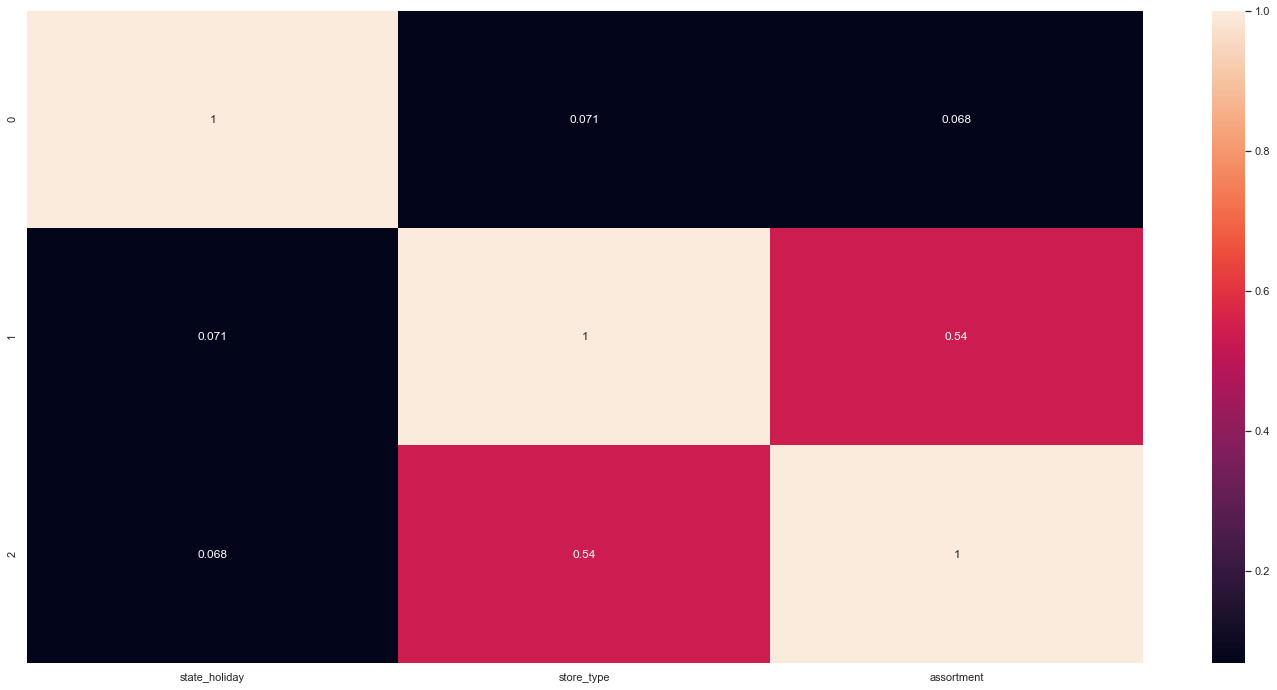

In [51]:
# only categorical attributes
a = df4.select_dtypes( include='object' )

# Calculate Cramer's V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
df = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

df.set_index( df.columns )

sns.heatmap( df, annot=True);

# 5.0. DATA PREPARATION

In [52]:
df5 = df4.copy()

## <s> 5.1. Normalization </s>

## 5.2. Rescaling

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

In [54]:
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )


## 5.3. Transformation

### 5.3.1. Encoding

In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_map = {'basic': 1, 'extra': 2, 'extended': 3}

df5['assortment'] = df5['assortment'].map( assortment_map )

### 5.3.2. Response Variable Transformation

In [56]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [57]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi / 7  ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi / 30  ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )

In [58]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and test dataset

In [60]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984


In [61]:
cols_drop = ['day_of_week', 'day', 'month', 'week_of_year', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [62]:
df6[ ['store', 'date'] ].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [63]:
# Training Dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
Y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Data: {}'.format( X_train['date'].min() ))
print('Training Min Data: {}'.format( X_train['date'].max() ))

print('\nTest Min Data: {}'.format( X_test['date'].min() ))
print('Test Min Data: {}'.format( X_test['date'].max() ))

Training Min Data: 2013-01-01 00:00:00
Training Min Data: 2015-06-18 00:00:00

Test Min Data: 2015-06-19 00:00:00
Test Min Data: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [64]:
# # Training and test for Boruta Selector
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = Y_train.values.ravel()

# # Instantiate RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 )
# boruta.fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [65]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d( x_train_fs.columns, cols_selected_boruta ))

In [66]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_sin',
    'day_cos',
    'month_sin', 
    'month_cos',
    'week_of_year_sin', 
    'week_of_year_cos']

# feat to add
feat_to_add = ['date', 'sales']

# final feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELING

In [67]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [69]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [70]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )

In [71]:
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [72]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, Y_train )

# predictio
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.45174


### 7.3.1. Lasso - Cross Validationn

In [73]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor Model

In [74]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 23).fit( x_train, Y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( Y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.825478,0.099886,1008.23033


### 7.4.1. Random Forest Model - Cross Validationn

In [75]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf )

In [76]:
rf_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,835.79 +/- 214.02,0.12 +/- 0.02,1253.0 +/- 313.3


## 7.5. XGBoost Regressor Model

In [77]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, Y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.688184,0.949474,7331.032701


### 7.5.1. XGBoost Regressor - Cross Validationn

In [78]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb )
xgb_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,7048.99 +/- 588.54,0.95 +/- 0.0,7714.97 +/- 689.31


## 7.6. Compare Model's Performance

### 7.6.1. Single Model Performance

In [79]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.825478,0.099886,1008.230330
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451740
0,XGBoost Regressor,6683.688184,0.949474,7331.032701


### 7.6.2. Real Model Performance

In [80]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE_CV' )

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,835.79 +/- 214.02,0.12 +/- 0.02,1253.0 +/- 313.3
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7048.99 +/- 588.54,0.95 +/- 0.0,7714.97 +/- 689.31


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [81]:
# params = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.3, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 10

In [82]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
    
#     # choose values for parameters randomly
#     hp = {k: sample(v, 1)[0] for k, v in params.items()}
#     print( hp )
#     # model
#     xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators = hp['n_estimators'], 
#                              eta=hp['eta'],
#                              max_depth=hp['max_depth'],
#                              subsample=hp['subsample'],
#                              colsample_bytree=hp['colsample_bytree'],
#                              min_child_weight=hp['min_child_weight'])

#     # performance
#     xgb_result_hp = cross_validation( x_training, 5 , 'XGBoost Regressor', xgb_model )
#     final_result = pd.concat( [final_result, xgb_result_hp ] )
    
# final_result

## 8.2 Final Model

In [84]:
final_model = pd.DataFrame()

params_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.3,
    'colsample_bytree': 0.9,
    'min_child_weight': 8
}

# model
xgb_model_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators = params_tuned['n_estimators'], 
                         eta=params_tuned['eta'],
                         max_depth=params_tuned['max_depth'],
                         subsample=params_tuned['subsample'],
                         colsample_bytree=params_tuned['colsample_bytree'],
                         min_child_weight=params_tuned['min_child_weight']).fit( x_train, Y_train )

# prediction
yhat_xgb_tuned = xgb_model_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned['MPE'] = mean_percentage_error( np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XGBoost Regressor,756.65275,0.113575,1090.460515,-0.018027


# 9.0. TRANSLATION AND MODEL'S INTERPRETATION

In [85]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [86]:
# sum of predictions
df91 = df9[ ['store', 'predictions'] ].groupby( 'store' ).sum().reset_index()

# MAE & MAPE
df9_aux1 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply( 
    lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'} )

df9_aux2 = df9[ ['store', 'sales', 'predictions'] ].groupby( 'store' ).apply( 
    lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Best & Worst Scenario
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Sorting columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [87]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
667,668,311074.500000,310394.927576,311754.072424,679.572424,0.075511
606,607,140581.750000,140071.446494,141092.053506,510.303506,0.220573
843,844,152060.953125,151612.021392,152509.884858,448.931733,0.130108
475,476,218867.781250,218251.968539,219483.593961,615.812711,0.151113


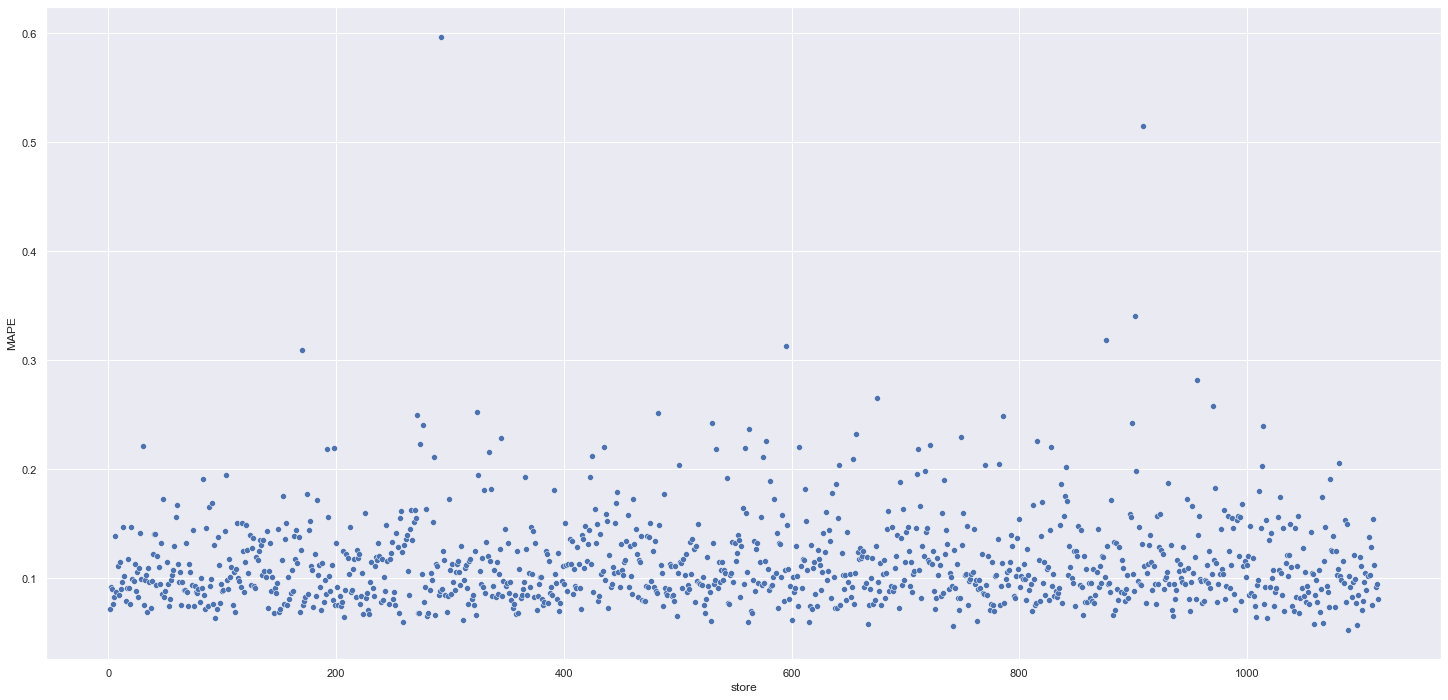

In [88]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2 Total Performance

In [89]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( 
    lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'scenario', 0: 'amount'} )
df93['amount'] = df93['amount'].map( '€{:,.2f}'.format )
df93.head()



,scenario,amount
0,predictions,"€286,723,264.00"
1,worst_scenario,"€285,876,384.80"
2,best_scenario,"€287,570,170.16"


## 9.3 Machine Learning Performance

In [90]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

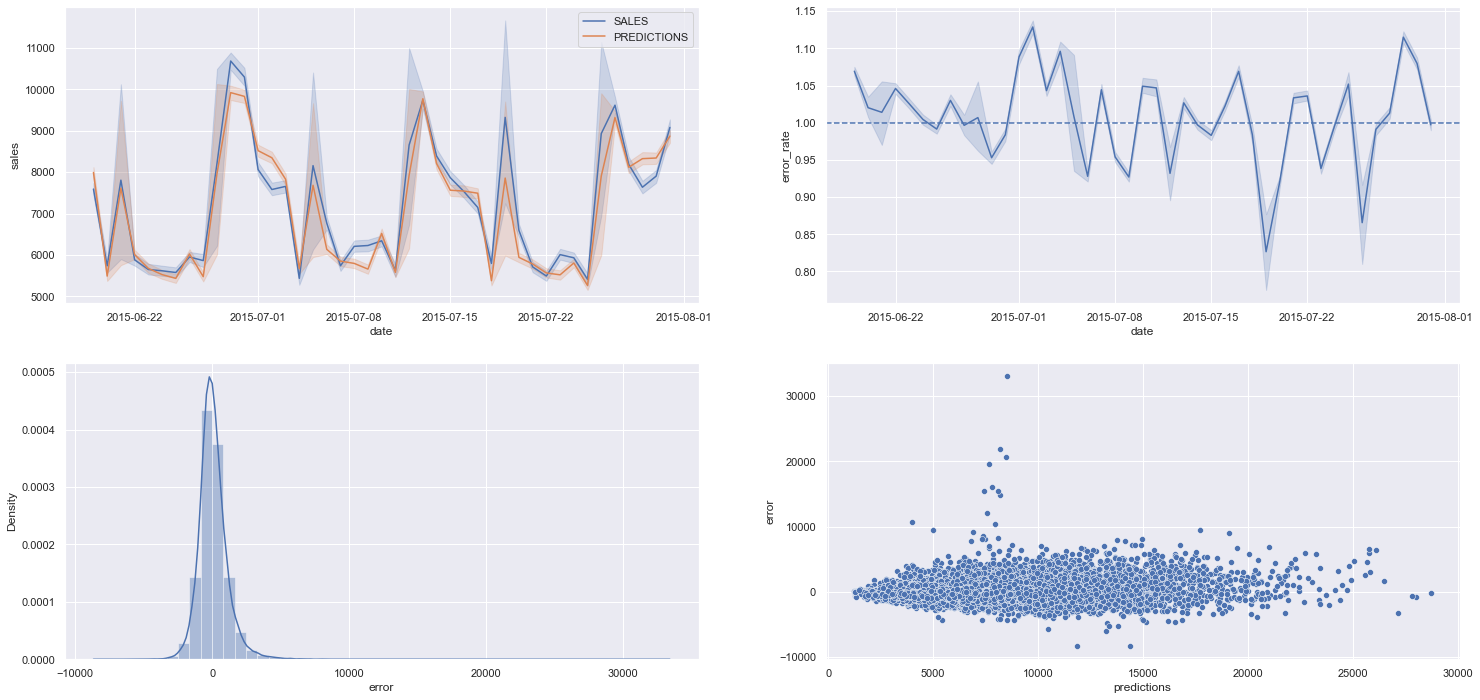

In [91]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] );

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

# 10.0. DEPLOY MODEL TO PRODUCTION

In [104]:
# save trained model
pickle.dump( xgb_model_tuned, open( '/Users/emidiovaleretoneto/DS/datascience-em-producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [106]:
class Rossmann(object):

    def __init__(self):
        self.home_path = '/Users/emidiovaleretoneto/DS/datascience-em-producao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        

    def data_cleaning(self, df1):
        # rename columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename columns
        df1.columns = cols_new

        # Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        # Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x[
                'competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x[
                'competition_open_since_year'],
            axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                     5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                     9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
            axis=1)

        # Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],
                                        day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(
            int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(
            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x == 'a' else "easter_holiday"
            if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # Row Filtering
        df2 = df2[ df2['open'] != 0 ]

        # Columns Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2
    

    def data_preparation(self, df5):

        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(
            df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(
            df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_map = {'basic': 1, 'extra': 2, 'extended': 3}

        df5['assortment'] = df5['assortment'].map(assortment_map)

        # Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                         'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]
    

    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )



## 10.2. API Handler

In [102]:
# loading model
model = pickle.load(open('/Users/emidiovaleretoneto/DS/datascience-em-producao/model/model_rossmann.pkl', 'rb'))

# initialise API
app = Flask(__name__)


@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # theres data

        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:  # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # instantitate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data prepatation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')


## 10.3. API Tester

In [123]:
df10 = pd.read_csv( 'data/test.csv' )

In [124]:
# merge test and store datasets

df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin([12, 22, 24])]

# remove days where stores haven't opened
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]

# remove index
df_test = df_test.drop( 'Id', axis=1 )

In [125]:
# converting dataframe into json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [126]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-predict.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [127]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [128]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print('>> Store no {} will sell €{:,.2f} in the next 6 weeks.'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

>> Store no 12 will sell €247,916.38 in the next 6 weeks.
>> Store no 22 will sell €147,446.01 in the next 6 weeks.
>> Store no 24 will sell €295,256.73 in the next 6 weeks.
